In [21]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [22]:
import os
import os.path as osp
import pandas as pd
import numpy as np
import scipy as sp
from functools import partial
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from scipy import interp
import scipy.stats as stats
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize


from sklearn.metrics import cohen_kappa_score as kappa, roc_auc_score, roc_curve, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import auc as auc_sk 
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, balanced_accuracy_score, accuracy_score, f1_score, matthews_corrcoef
from sklearn.utils import resample

from sklearn.model_selection import train_test_split

from tqdm import tqdm, trange
from tqdm import tqdm_notebook as tqdm
import warnings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from evaluation.evaluate import eval_predictions_multi

In [24]:
def get_perf(subset):
    probas = np.vstack([subset.y_proba_0, subset.y_proba_1, 
                     subset.y_proba_2, subset.y_proba_3, 
                     subset.y_proba_4]).T
    c_aucs = []
    n_classes = len(np.unique(subset.y_true))
    for c in range(n_classes):
        y_true_c = subset.y_true.copy()
        c_idx = subset.y_true == c
        y_true_c[y_true_c != c] = 0
        y_true_c[c_idx] = 1
        c_aucs.append(roc_auc_score(y_true_c, probas[:, c]))

    acc = balanced_accuracy_score(subset.y_true, subset.y_pred)
    k = kappa(subset.y_true, subset.y_pred, weights='quadratic')
    mean_auc = roc_auc_score(subset.y_true, probas, average='weighted', multi_class='ovo')
    return acc, k, c_aucs, mean_auc

In [25]:
def get_other_perf(results):   
    mcc = matthews_corrcoef(results.y_true, results.y_pred)
    kendall, p = stats.kendalltau(results.y_true, results.y_pred)
    pearson, p = stats.spearmanr(results.y_true, results.y_pred)
    spearman, p = stats.pearsonr(results.y_true, results.y_pred)
    w_f1 = f1_score(results.y_true, results.y_pred, average='weighted')
    w_recall = recall_score(results.y_true, results.y_pred, average='weighted')
    w_precision = precision_score(results.y_true, results.y_pred, average='weighted')
    return mcc, kendall, pearson, spearman, w_f1, w_recall, w_precision

In [26]:
def get_perf_stats(k_bootstrap_gls, c_aucs_bootstrap_gls, m_auc_bootstrap_gls, w_precision_bootstrap_gls, w_recall_bootstrap_gls, 
                   w_f1_bootstrap_gls, mcc_bootstrap_gls, kendall_bootstrap_gls, 
                   k_bootstrap_ce,  c_aucs_bootstrap_ce, m_auc_bootstrap_ce, w_precision_bootstrap_ce,  w_recall_bootstrap_ce, 
                   w_f1_bootstrap_ce,  mcc_bootstrap_ce,  kendall_bootstrap_ce):
    print('Mean kappa:', np.mean(k_bootstrap_gls), ' vs ', np.mean(k_bootstrap_ce))
    z = np.array([k_bootstrap_gls[i] - k_bootstrap_ce[i] for i in range(n_iters)])
    print('Mean Sigma kappa:', np.mean(z), 'p-value:', (np.sum(z<0))/len(z))
    print(55*'-')
    print('Mean M-AUC:', np.mean(m_auc_bootstrap_gls), ' vs ', np.mean(m_auc_bootstrap_ce))
    z = np.array([m_auc_bootstrap_gls[i] - m_auc_bootstrap_ce[i] for i in range(n_iters)])
    print('Mean Sigma M-AUC:', np.mean(z), 'p-value:', (np.sum(z<0))/len(z))
    print(55*'-')
    for c in range(5):
        print('Class DR', str(c))
        print('Mean AUC:', np.mean(np.array(c_aucs_bootstrap_gls)[:,c]), ' vs ', np.mean(np.array(c_aucs_bootstrap_ce)[:,c]))
        z = np.array(c_aucs_bootstrap_gls)[:,c] - np.array(c_aucs_bootstrap_ce)[:,c]
        print('Mean Sigma AUC:', np.mean(z), 'p-value:', (np.sum(z<0))/len(z))
        print(55*'-')
    print(55*'-')
    
    macro_aucs_bootstrap_gls = np.mean(np.array(c_aucs_bootstrap_gls), axis=1)
    macro_aucs_bootstrap_ce = np.mean(np.array(c_aucs_bootstrap_ce), axis=1)
    print('Mean Macro-AUC:', np.mean(macro_aucs_bootstrap_gls), ' vs ', np.mean(macro_aucs_bootstrap_ce))
    z = np.array([macro_aucs_bootstrap_gls[i] - macro_aucs_bootstrap_ce[i] for i in range(n_iters)])
    print('Mean Sigma Macro-AUC:', np.mean(z), 'p-value:', (np.sum(z<0))/len(z))
    print(55*'-')
    
    print('Mean Weighted Precision:', np.mean(w_precision_bootstrap_gls), ' vs ', np.mean(w_precision_bootstrap_ce))
    z = np.array([w_precision_bootstrap_gls[i] - w_precision_bootstrap_ce[i] for i in range(n_iters)])
    print('Mean Sigma Weighted Precision:', np.mean(z), 'p-value:', (np.sum(z<0))/len(z))
    print(55*'-')

    print('Mean Weighted Recall:', np.mean(w_recall_bootstrap_gls), ' vs ', np.mean(w_recall_bootstrap_ce))
    z = np.array([w_recall_bootstrap_gls[i] - w_recall_bootstrap_ce[i] for i in range(n_iters)])
    print('Mean Sigma Weighted Recall:', np.mean(z), 'p-value:', (np.sum(z<0))/len(z))
    print(55*'-')

    print('Mean Weighted F1:', np.mean(w_f1_bootstrap_gls), ' vs ', np.mean(w_f1_bootstrap_ce))
    z = np.array([w_f1_bootstrap_gls[i] - w_f1_bootstrap_ce[i] for i in range(n_iters)])
    print('Mean Sigma Weighted F1:', np.mean(z), 'p-value:', (np.sum(z<0))/len(z))
    print(55*'-')

    print('Mean MCC:', np.mean(mcc_bootstrap_gls), ' vs ', np.mean(mcc_bootstrap_ce))
    z = np.array([mcc_bootstrap_gls[i] - mcc_bootstrap_ce[i] for i in range(n_iters)])
    print('Mean Sigma MCC:', np.mean(z), 'p-value:', (np.sum(z<0))/len(z))
    print(55*'-')

    print('Mean Kendall Tau:', np.mean(kendall_bootstrap_gls), ' vs ', np.mean(kendall_bootstrap_ce))
    z = np.array([kendall_bootstrap_gls[i] - kendall_bootstrap_ce[i] for i in range(n_iters)])
    print('Mean Sigma Kendall Tau:', np.mean(z), 'p-value:', (np.sum(z<0))/len(z))
    print(55*'-')

In [27]:
def load_results(ev_set, loss, checkpoint, oversample, N):
    model_path = PATH_MODELS+'/'+folders_dict[loss]+oversample+'/'+'checkpoint'+checkpoint+'.pth'
#     print('model used: '+model_path)
    tta = '_TTA'+str(N)
    save_name = 'results_'+ev_set+checkpoint+tta+'.npy'
    save_path = PATH_MODELS+'/'+folders_dict[loss]+oversample+'/'+save_name
    
    print('loading results from ' + folders_dict[loss]+oversample+'/'+'checkpoint'+checkpoint+'.pth', ', TTA = '+str(N))
    results = np.load(save_path)
    return results

In [28]:
def get_results_all(rr_ce, rr_uls, rr_gls):
    return pd.DataFrame({'y_true_ce':rr_ce[:,1],
                           'y_proba_0_ce':rr_ce[:,2],
                           'y_proba_1_ce':rr_ce[:,3],
                           'y_proba_2_ce':rr_ce[:,4],
                           'y_proba_3_ce':rr_ce[:,5],
                           'y_proba_4_ce':rr_ce[:,6],
                           'y_pred_ce':rr_ce[:,0],

                           'y_proba_0_uls':rr_uls[:,2],
                           'y_proba_1_uls':rr_uls[:,3],
                           'y_proba_2_uls':rr_uls[:,4],
                           'y_proba_3_uls':rr_uls[:,5],
                           'y_proba_4_uls':rr_uls[:,6],
                           'y_pred_uls':rr_uls[:,0],

                           'y_proba_0_gls':rr_gls[:,2],
                           'y_proba_1_gls':rr_gls[:,3],
                           'y_proba_2_gls':rr_gls[:,4],
                           'y_proba_3_gls':rr_gls[:,5],
                           'y_proba_4_gls':rr_gls[:,6],
                           'y_pred_gls':rr_gls[:,0]
                          })

# For Resnet101 results

In [29]:
PATH_MODELS = 'new/'

In [30]:
model_name = 'resnet101'

folders_dict = {'ce':'DR_'+model_name+'_ce',
                'uls': 'DR_'+model_name+'_label_smoothing_U',
                'gls': 'DR_'+model_name+'_label_smoothing_G'}

In [31]:
ev_set = 'test'
# oversample = '_oversampled'
oversample = ''

In [32]:
N=4

loss = 'ce'
checkpoint = '_mauc'
# checkpoint = '_kappa'
rr_ce = load_results(ev_set, loss, checkpoint, oversample, N)

loss = 'uls'
checkpoint = '_mauc'
# checkpoint = '_kappa'
rr_uls = load_results(ev_set, loss, checkpoint, oversample, N)

loss = 'gls'
checkpoint = '_kappa'
# checkpoint = '_kappa'
rr_gls = load_results(ev_set, loss, checkpoint, oversample, N)

results_all = get_results_all(rr_ce, rr_uls, rr_gls)

loading results from DR_resnet101_ce/checkpoint_mauc.pth , TTA = 4
loading results from DR_resnet101_label_smoothing_U/checkpoint_mauc.pth , TTA = 4
loading results from DR_resnet101_label_smoothing_G/checkpoint_kappa.pth , TTA = 4


In [33]:
acc_bootstrap_ce, k_bootstrap_ce, c_aucs_bootstrap_ce, m_auc_bootstrap_ce     = [], [], [], []
acc_bootstrap_uls, k_bootstrap_uls, c_aucs_bootstrap_uls, m_auc_bootstrap_uls = [], [], [], []
acc_bootstrap_gls, k_bootstrap_gls, c_aucs_bootstrap_gls, m_auc_bootstrap_gls = [], [], [], []
mcc_bootstrap_ce, mcc_bootstrap_uls, mcc_bootstrap_gls = [], [], []
kendall_bootstrap_ce, kendall_bootstrap_uls, kendall_bootstrap_gls = [], [], []
pearson_bootstrap_ce, pearson_bootstrap_uls, pearson_bootstrap_gls = [], [], []
spearman_bootstrap_ce, spearman_bootstrap_uls, spearman_bootstrap_gls = [], [], []
w_f1_bootstrap_ce, w_f1_bootstrap_uls, w_f1_bootstrap_gls = [], [], []
w_recall_bootstrap_ce, w_recall_bootstrap_uls, w_recall_bootstrap_gls = [], [], []
w_precision_bootstrap_ce, w_precision_bootstrap_uls, w_precision_bootstrap_gls = [], [], []

In [34]:
n_iters = 1000

In [35]:
for seed in tqdm(range(n_iters)):
    subset = resample(results_all, n_samples=None, replace=True, random_state=seed, stratify = results_all['y_true_ce'])
    
    subset_ce = subset[['y_true_ce', 'y_pred_ce', 'y_proba_0_ce', 'y_proba_1_ce', 'y_proba_2_ce','y_proba_3_ce', 'y_proba_4_ce']]
    subset_ce = subset_ce.rename(columns=lambda x: x.replace('_ce', ''))
    
    subset_uls = subset[['y_true_ce', 'y_pred_uls', 'y_proba_0_uls', 'y_proba_1_uls', 'y_proba_2_uls','y_proba_3_uls', 'y_proba_4_uls']]
    subset_uls = subset_uls.rename(columns=lambda x: x.replace('_ce', '').replace('_uls', ''))
    
    subset_gls = subset[['y_true_ce', 'y_pred_gls', 'y_proba_0_gls', 'y_proba_1_gls', 'y_proba_2_gls','y_proba_3_gls', 'y_proba_4_gls']]
    subset_gls = subset_gls.rename(columns=lambda x: x.replace('_ce', '').replace('_gls', ''))
    
    acc_ce, k_ce, c_aucs_ce, m_auc_ce = get_perf(subset_ce)
    mcc_ce, kendall_ce, pearson_ce, spearman_ce, w_f1_ce, w_recall_ce, w_precision_ce = get_other_perf(subset_ce)
    
    acc_uls, k_uls, c_aucs_uls, m_auc_uls = get_perf(subset_uls)
    mcc_uls, kendall_uls, pearson_uls, spearman_uls, w_f1_uls, w_recall_uls, w_precision_uls = get_other_perf(subset_uls)
    
    acc_gls, k_gls, c_aucs_gls, m_auc_gls = get_perf(subset_gls)
    mcc_gls, kendall_gls, pearson_gls, spearman_gls, w_f1_gls, w_recall_gls, w_precision_gls = get_other_perf(subset_gls)
    
    acc_bootstrap_ce.append(acc_ce)
    k_bootstrap_ce.append(k_ce)
    c_aucs_bootstrap_ce.append(c_aucs_ce)
    m_auc_bootstrap_ce.append(m_auc_ce)
    mcc_bootstrap_ce.append(mcc_ce)
    kendall_bootstrap_ce.append(kendall_ce)
    pearson_bootstrap_ce.append(pearson_ce)
    spearman_bootstrap_ce.append(spearman_ce)
    w_f1_bootstrap_ce.append(w_f1_ce)
    w_recall_bootstrap_ce.append(w_recall_ce)
    w_precision_bootstrap_ce.append(w_precision_ce)
    
    acc_bootstrap_uls.append(acc_uls)
    k_bootstrap_uls.append(k_uls)
    c_aucs_bootstrap_uls.append(c_aucs_uls)
    m_auc_bootstrap_uls.append(m_auc_uls)
    mcc_bootstrap_uls.append(mcc_uls)
    kendall_bootstrap_uls.append(kendall_uls)
    pearson_bootstrap_uls.append(pearson_uls)
    spearman_bootstrap_uls.append(spearman_uls)
    w_f1_bootstrap_uls.append(w_f1_uls)
    w_recall_bootstrap_uls.append(w_recall_uls)
    w_precision_bootstrap_uls.append(w_precision_uls)
    
    
    acc_bootstrap_gls.append(acc_gls)
    k_bootstrap_gls.append(k_gls)
    c_aucs_bootstrap_gls.append(c_aucs_gls)
    m_auc_bootstrap_gls.append(m_auc_gls)
    mcc_bootstrap_gls.append(mcc_gls)
    kendall_bootstrap_gls.append(kendall_gls)
    pearson_bootstrap_gls.append(pearson_gls)
    spearman_bootstrap_gls.append(spearman_gls)
    w_f1_bootstrap_gls.append(w_f1_gls)
    w_recall_bootstrap_gls.append(w_recall_gls)
    w_precision_bootstrap_gls.append(w_precision_gls)
    

/home/agaldran/anaconda3/envs/vessels/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [37]:
print('GLS vs CE comparison:')
get_perf_stats(k_bootstrap_gls, c_aucs_bootstrap_gls, m_auc_bootstrap_gls, w_precision_bootstrap_gls, w_recall_bootstrap_gls, 
                   w_f1_bootstrap_gls, mcc_bootstrap_gls, kendall_bootstrap_gls, 
                   k_bootstrap_ce,  c_aucs_bootstrap_ce,  m_auc_bootstrap_ce, w_precision_bootstrap_ce,  w_recall_bootstrap_ce, 
                   w_f1_bootstrap_ce,  mcc_bootstrap_ce,  kendall_bootstrap_ce)

GLS vs CE comparison:
Mean kappa: 0.7719525929934141  vs  0.7197987263022956
Mean Sigma kappa: 0.052153866691118565 p-value: 0.0
-------------------------------------------------------
Mean M-AUC: 0.9101623258980623  vs  0.9148280243742747
Mean Sigma M-AUC: -0.004665698476212351 p-value: 0.881
-------------------------------------------------------
Class DR 0
Mean AUC: 0.9483783960627512  vs  0.9461935200921002
Mean Sigma AUC: 0.002184875970651008 p-value: 0.196
-------------------------------------------------------
Class DR 1
Mean AUC: 0.771185035286873  vs  0.79261197201358
Mean Sigma AUC: -0.02142693672670701 p-value: 0.887
-------------------------------------------------------
Class DR 2
Mean AUC: 0.9500034541651475  vs  0.935715826880034
Mean Sigma AUC: 0.014287627285113413 p-value: 0.0
-------------------------------------------------------
Class DR 3
Mean AUC: 0.9539815641793628  vs  0.957443886984635
Mean Sigma AUC: -0.0034623228052723244 p-value: 0.569
----------------------

In [38]:
print('GLS vs ULS comparison:')
get_perf_stats(k_bootstrap_gls, c_aucs_bootstrap_gls, m_auc_bootstrap_gls, w_precision_bootstrap_gls, w_recall_bootstrap_gls, 
                   w_f1_bootstrap_gls, mcc_bootstrap_gls, kendall_bootstrap_gls, 
                   k_bootstrap_uls,  c_aucs_bootstrap_uls, m_auc_bootstrap_uls,  w_precision_bootstrap_uls,  w_recall_bootstrap_uls, 
                   w_f1_bootstrap_uls,  mcc_bootstrap_uls,  kendall_bootstrap_uls)

GLS vs ULS comparison:
Mean kappa: 0.7719525929934141  vs  0.7452329862376935
Mean Sigma kappa: 0.026719606755720545 p-value: 0.007
-------------------------------------------------------
Mean M-AUC: 0.9101623258980623  vs  0.9126524243693636
Mean Sigma M-AUC: -0.0024900984713012277 p-value: 0.723
-------------------------------------------------------
Class DR 0
Mean AUC: 0.9483783960627512  vs  0.9439513667367557
Mean Sigma AUC: 0.004427029325995496 p-value: 0.037
-------------------------------------------------------
Class DR 1
Mean AUC: 0.771185035286873  vs  0.7884057605516257
Mean Sigma AUC: -0.01722072526475283 p-value: 0.858
-------------------------------------------------------
Class DR 2
Mean AUC: 0.9500034541651475  vs  0.9429470919592967
Mean Sigma AUC: 0.007056362205850791 p-value: 0.01
-------------------------------------------------------
Class DR 3
Mean AUC: 0.9539815641793628  vs  0.9479478823135062
Mean Sigma AUC: 0.006033681865856425 p-value: 0.352
---------------

# OLD
## Comparisons one by one

In [18]:
results_ce = pd.DataFrame({'y_pred':rr_ce[:,0], 
                            'y_true':rr_ce[:,1],
                            'y_proba_0':rr_ce[:,2],
                            'y_proba_1':rr_ce[:,3],
                            'y_proba_2':rr_ce[:,4],
                            'y_proba_3':rr_ce[:,5],
                           'y_proba_4':rr_ce[:,6],
                       })

In [19]:
results_uls = pd.DataFrame({'y_pred':rr_uls[:,0], 
                            'y_true':rr_uls[:,1],
                            'y_proba_0':rr_uls[:,2],
                            'y_proba_1':rr_uls[:,3],
                            'y_proba_2':rr_uls[:,4],
                            'y_proba_3':rr_uls[:,5],
                            'y_proba_4':rr_uls[:,6],
                       })

In [20]:
results_gls = pd.DataFrame({'y_pred':rr_gls[:,0], 
                            'y_true':rr_gls[:,1],
                            'y_proba_0':rr_gls[:,2],
                            'y_proba_1':rr_gls[:,3],
                            'y_proba_2':rr_gls[:,4],
                            'y_proba_3':rr_gls[:,5],
                            'y_proba_4':rr_gls[:,6],
                       })

### ROC for each class individually, bootstrapped

In [21]:
colors = ['darksalmon', 'gold', 'royalblue', 'mediumseagreen', 'violet']

In [22]:
params = {'legend.fontsize': 25,
          'figure.figsize': (15, 15),
          'axes.labelsize': 20,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
# plt.rcParams.update({'font.size': 22})
plt.rcParams.update(params)

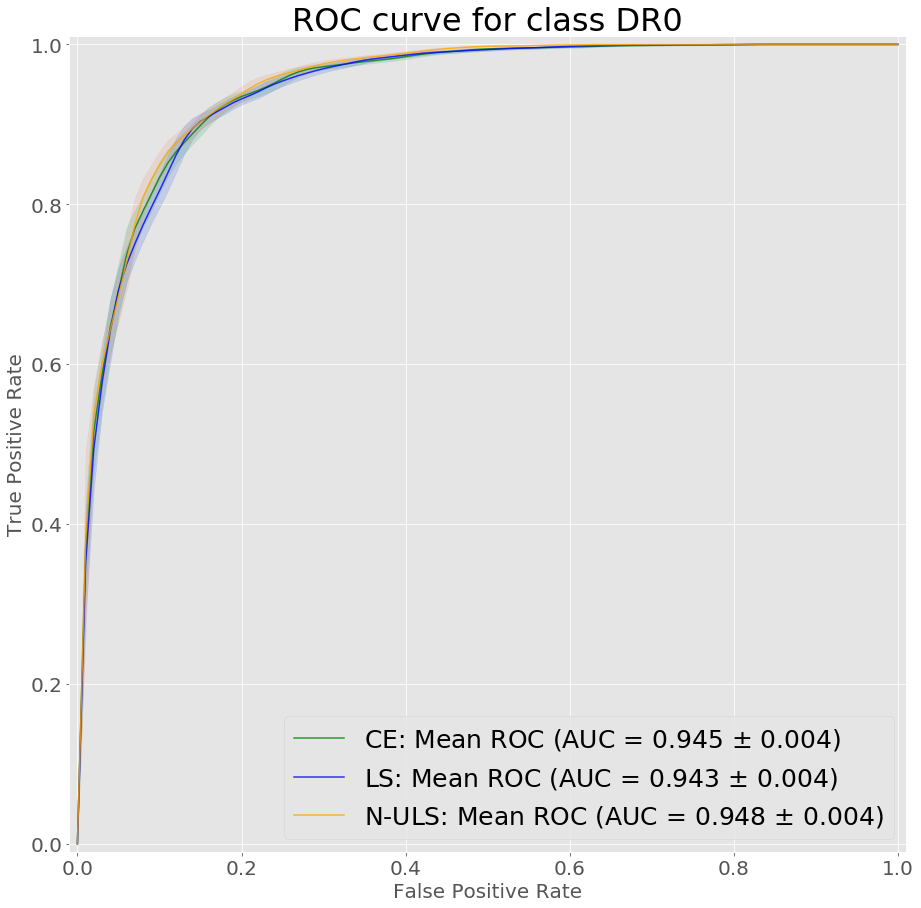

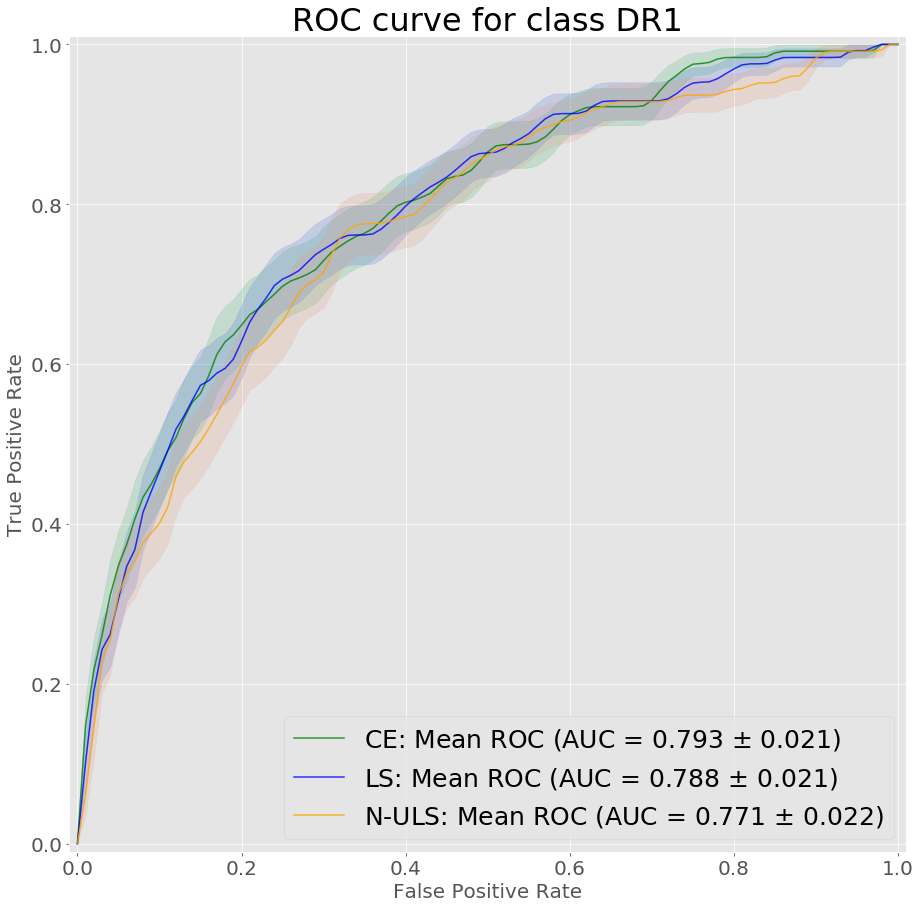

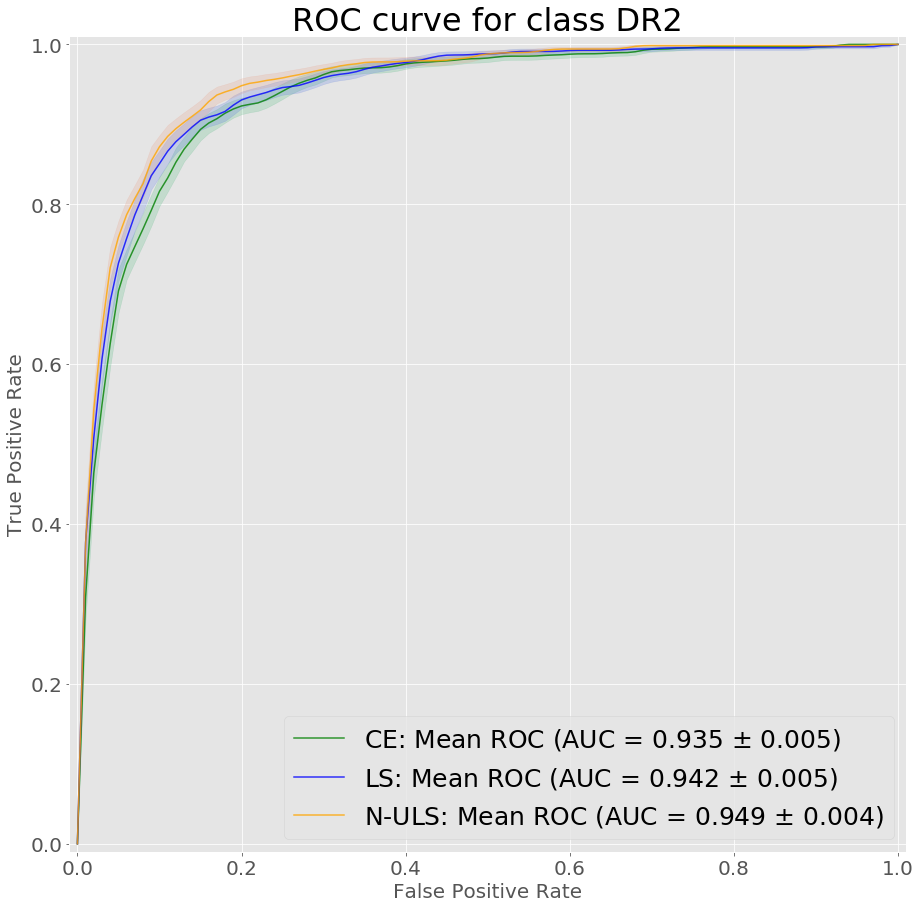

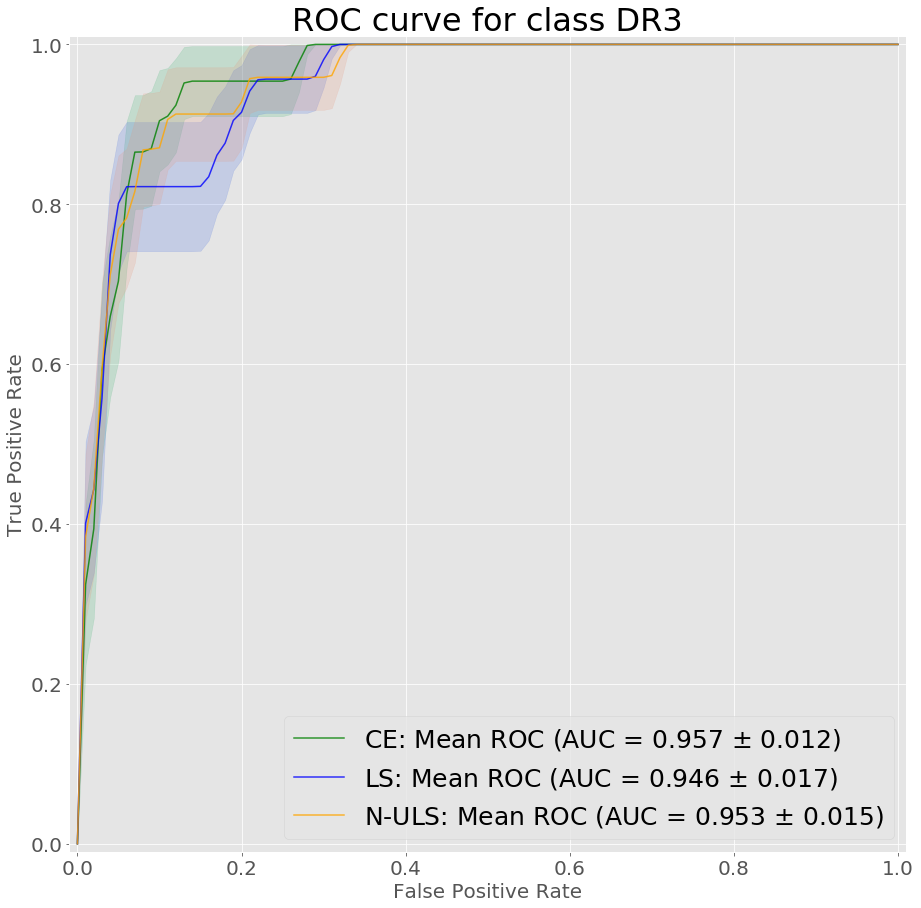

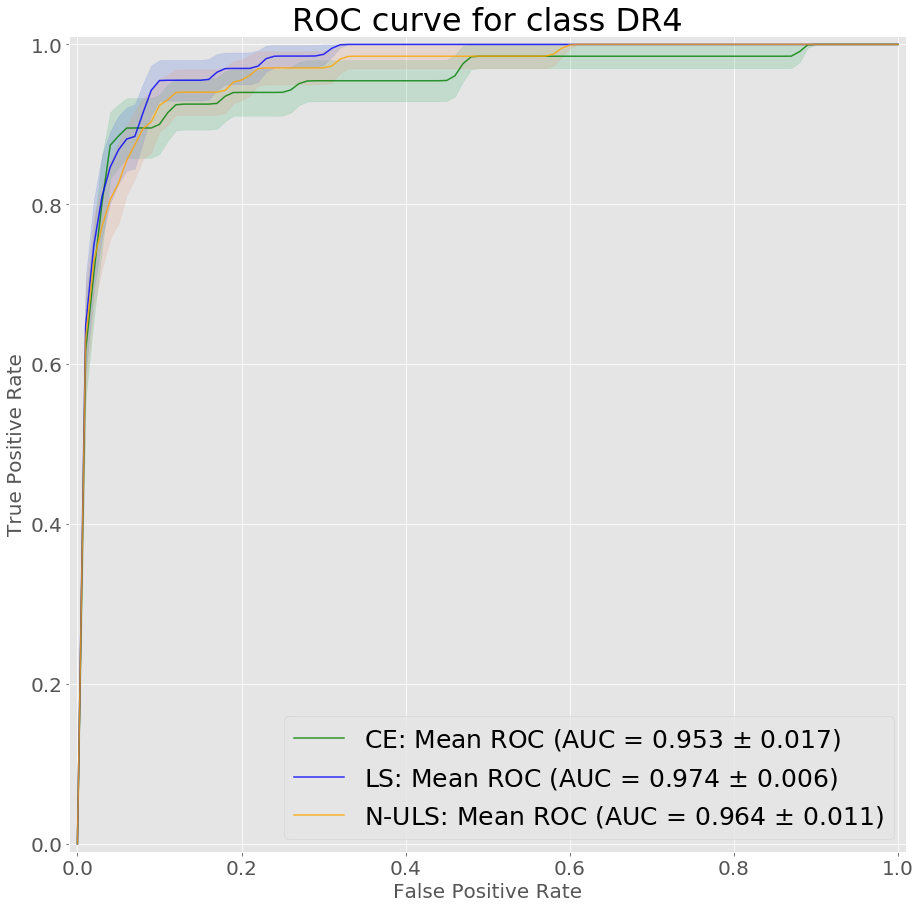

In [23]:
for c in range(5):
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)

    for seed in tqdm(range(1000)):
        subset = resample(results_ce, n_samples=None, replace=True, random_state=seed, stratify = results_ce['y_true'])
        probas = np.vstack([subset.y_proba_0, subset.y_proba_1, 
                            subset.y_proba_2, subset.y_proba_3, 
                            subset.y_proba_4]).T
        y_score = probas[:, c]
        y_true_c = subset.y_true.copy()
        c_idx = subset.y_true == c
        y_true_c[y_true_c != c] = 0
        y_true_c[c_idx] = 1

        fpr, tpr, _ = roc_curve(y_true_c, y_score)
        roc_auc = auc_sk(fpr, tpr)
        aucs.append(roc_auc)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_auc = np.around(auc_sk(base_fpr, mean_tprs), decimals=3)
    std_auc = np.around(np.std(aucs), decimals=3)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    f = plt.figure()
    plt.plot(base_fpr, mean_tprs, color='green', alpha = 0.8, label=r'CE: Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'mediumseagreen', alpha = 0.2)
    
    ##############################################################
    
    
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)

    for seed in tqdm(range(1000)):
        subset = resample(results_uls, n_samples=None, replace=True, random_state=seed, stratify = results_uls['y_true'])
        probas = np.vstack([subset.y_proba_0, subset.y_proba_1, 
                            subset.y_proba_2, subset.y_proba_3, 
                            subset.y_proba_4]).T
        y_score = probas[:, c]
        y_true_c = subset.y_true.copy()
        c_idx = subset.y_true == c
        y_true_c[y_true_c != c] = 0
        y_true_c[c_idx] = 1

        fpr, tpr, _ = roc_curve(y_true_c, y_score)
        roc_auc = auc_sk(fpr, tpr)
        aucs.append(roc_auc)
        #plt.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc), c = colors[i])
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_auc = np.around(auc_sk(base_fpr, mean_tprs), decimals=3)
    std_auc = np.around(np.std(aucs), decimals=3)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std


    plt.plot(base_fpr, mean_tprs, 'b', alpha = 0.8, label=r'LS: Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'royalblue', alpha = 0.2)
    ##############################################################
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)

    for seed in tqdm(range(1000)):
        subset = resample(results_gls, n_samples=None, replace=True, random_state=seed, stratify = results_gls['y_true'])
        probas = np.vstack([subset.y_proba_0, subset.y_proba_1, 
                            subset.y_proba_2, subset.y_proba_3, 
                            subset.y_proba_4]).T
        y_score = probas[:, c]
        y_true_c = subset.y_true.copy()
        c_idx = subset.y_true == c
        y_true_c[y_true_c != c] = 0
        y_true_c[c_idx] = 1

        fpr, tpr, _ = roc_curve(y_true_c, y_score)
        roc_auc = auc_sk(fpr, tpr)
        aucs.append(roc_auc)
        #plt.plot(fpr, tpr, lw=1, alpha=0.6, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc), c = colors[i])
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_auc = np.around(auc_sk(base_fpr, mean_tprs), decimals=3)
    std_auc = np.around(np.std(aucs), decimals=3)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    plt.plot(base_fpr, mean_tprs, color='orange', alpha = 0.8, label=r'N-ULS: Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'darksalmon', alpha = 0.2)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')#, fontsize=14
    plt.xlabel('False Positive Rate')#, fontsize=14
    plt.legend(loc="lower right")#, fontsize=15
    plt.title('ROC curve for class DR'+str(c), fontsize=32)#, fontsize=15
    plt.show()
    fig_title = 'ROCs_grade'+str(c)+'_R101.png'
    f.savefig(fig_title, bbox_inches='tight')

In [24]:
from skimage.io import imread, imsave

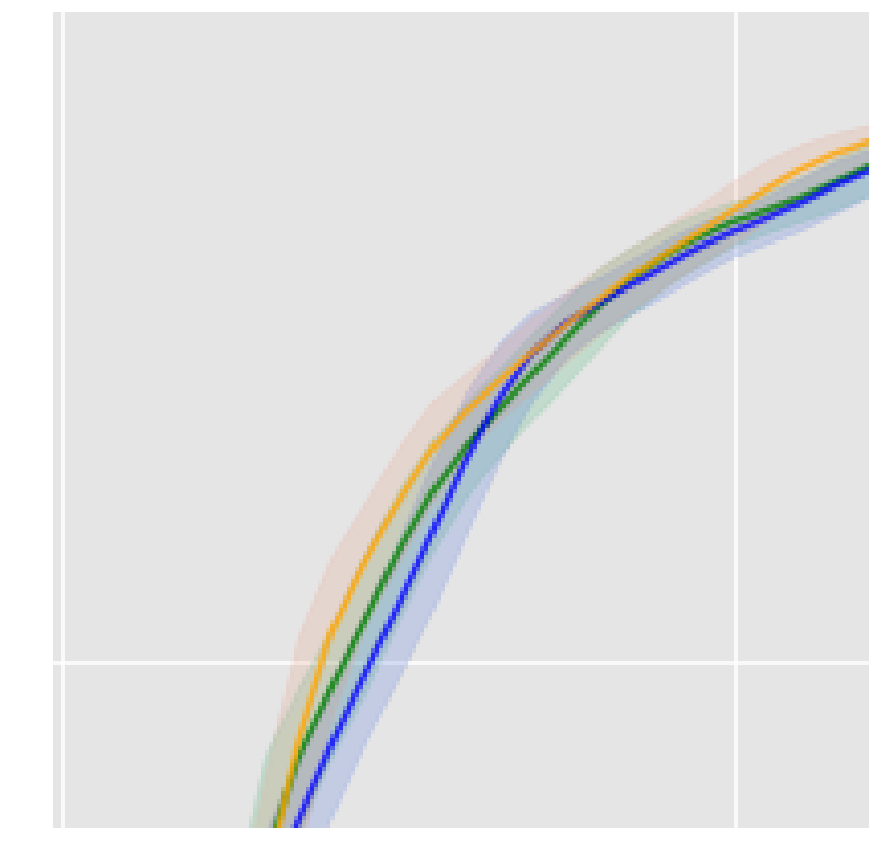

In [25]:
corner = imread('ROCs_grade0_R101.png')
corner.shape
c1, c2 = 45, 75
c3, c4 = c1+200, c2+200
plt.imshow(corner[c1:c3,c2:c4,:])
plt.axis('off')
imsave('corner0_R101.png', corner[c1:c3,c2:c4,:])

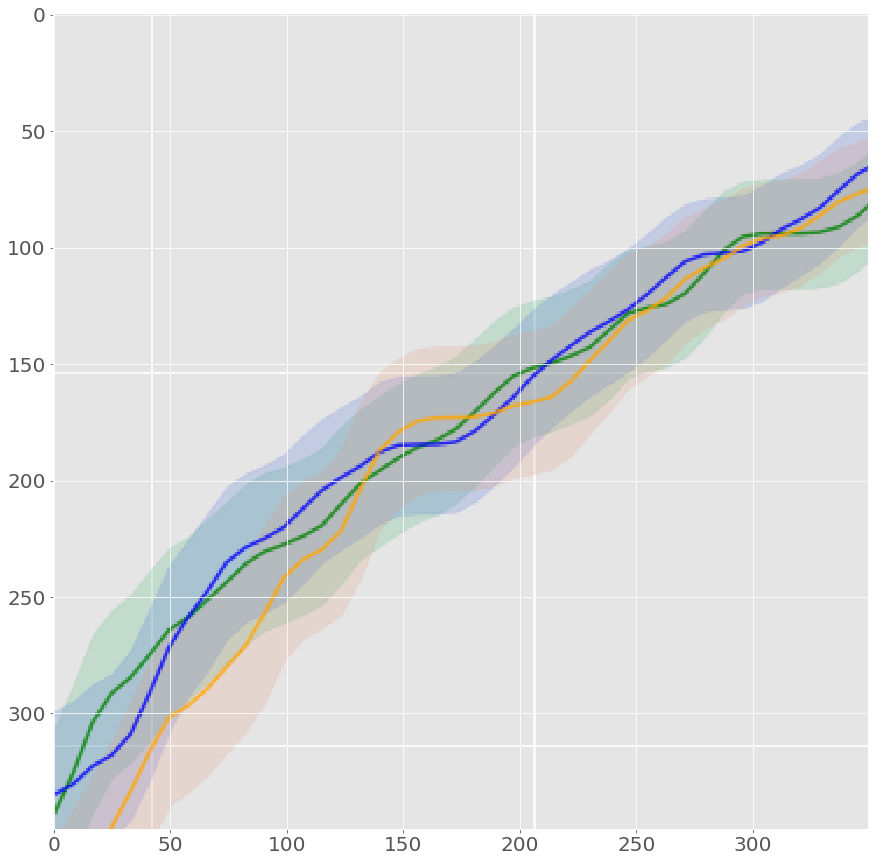

In [26]:
corner = imread('ROCs_grade1_R101.png')
corner.shape
c1, c2 = 50, 200
c3, c4 = c1+350, c2+350
plt.imshow(corner[c1:c3,c2:c4,:])
imsave('corner1_R101.png', corner[c1:c3,c2:c4,:])

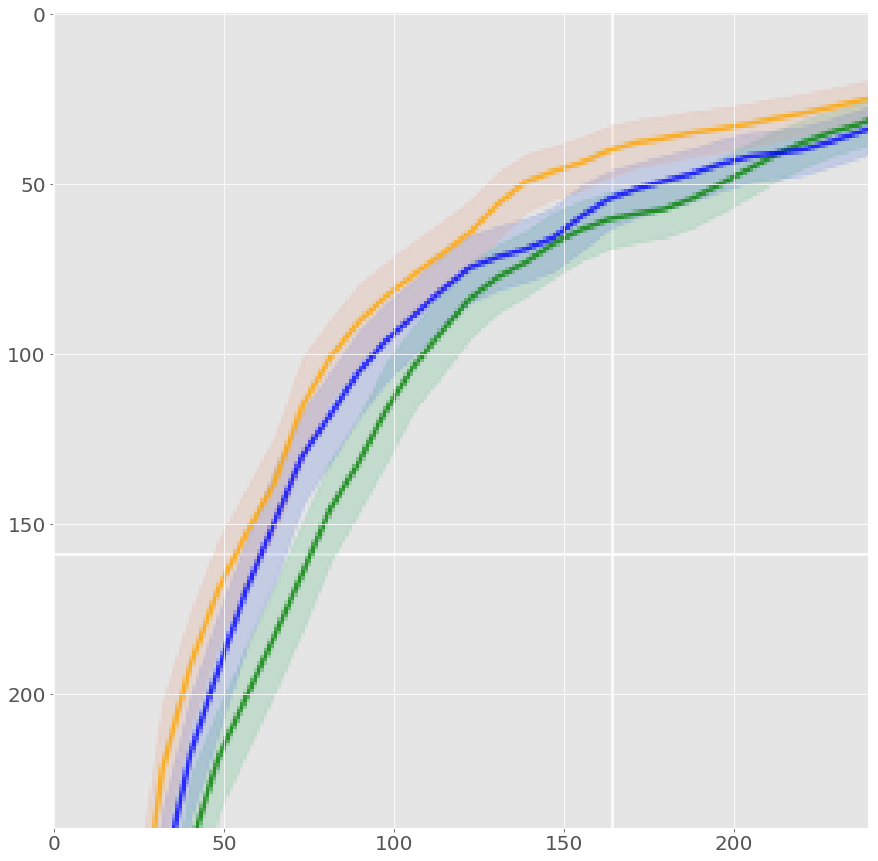

In [27]:
corner = imread('ROCs_grade2_R101.png')
corner.shape
c1, c2 = 45, 78
c3, c4 = c1+240, c2+240
plt.imshow(corner[c1:c3,c2:c4,:])
imsave('corner2_R101.png', corner[c1:c3,c2:c4,:])

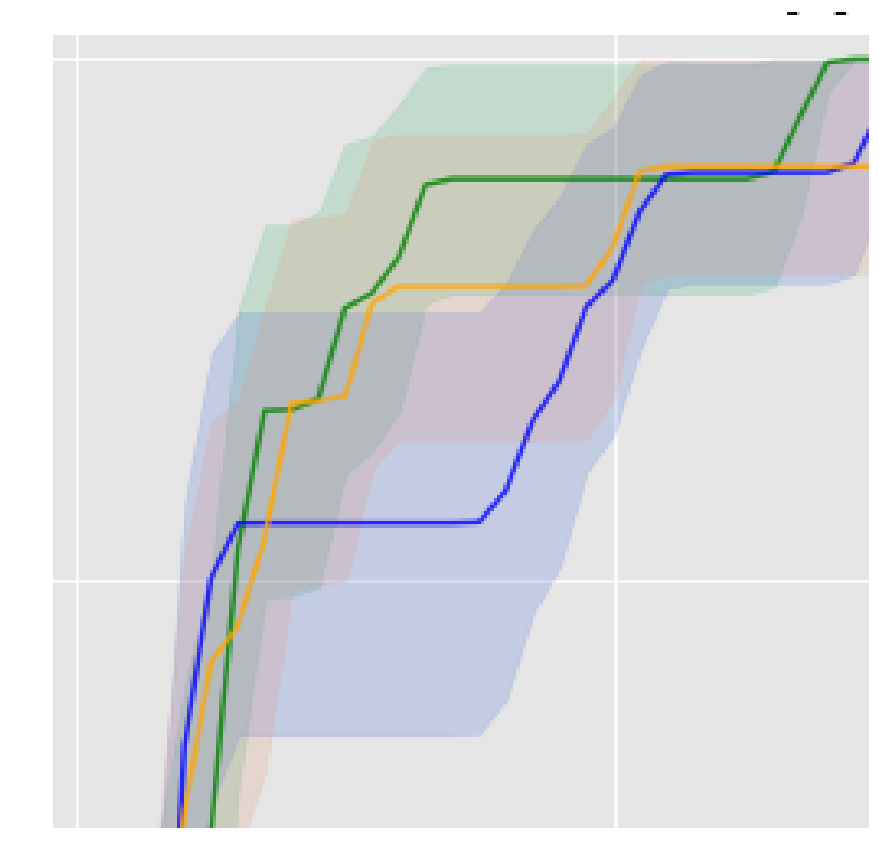

In [28]:
corner = imread('ROCs_grade3_R101.png')
corner.shape
c1, c2 = 30, 70
c3, c4 = c1+250, c2+250
plt.imshow(corner[c1:c3,c2:c4,:])
plt.axis('off')
imsave('corner3_R101.png', corner[c1:c3,c2:c4,:])

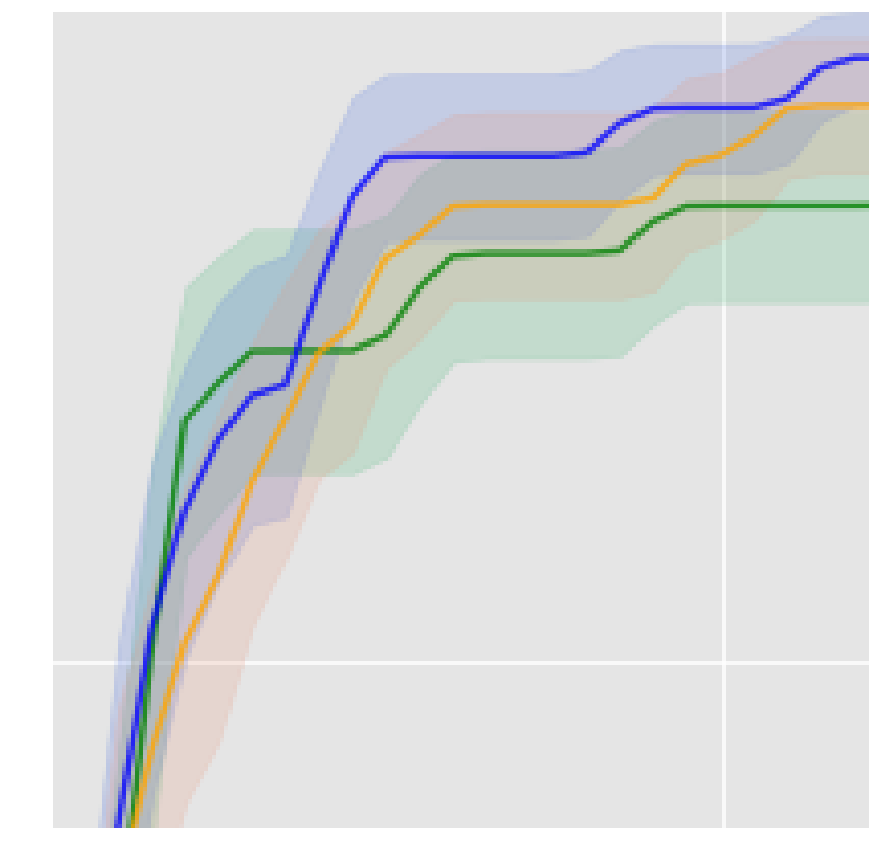

In [29]:
corner = imread('ROCs_grade4_R101.png')
corner.shape
c1, c2 = 45, 78
c3, c4 = c1+200, c2+200
plt.imshow(corner[c1:c3,c2:c4,:])
plt.axis('off')
imsave('corner4_R101.png', corner[c1:c3,c2:c4,:])

### MACRO-AUC

In [30]:
method='MACRO'

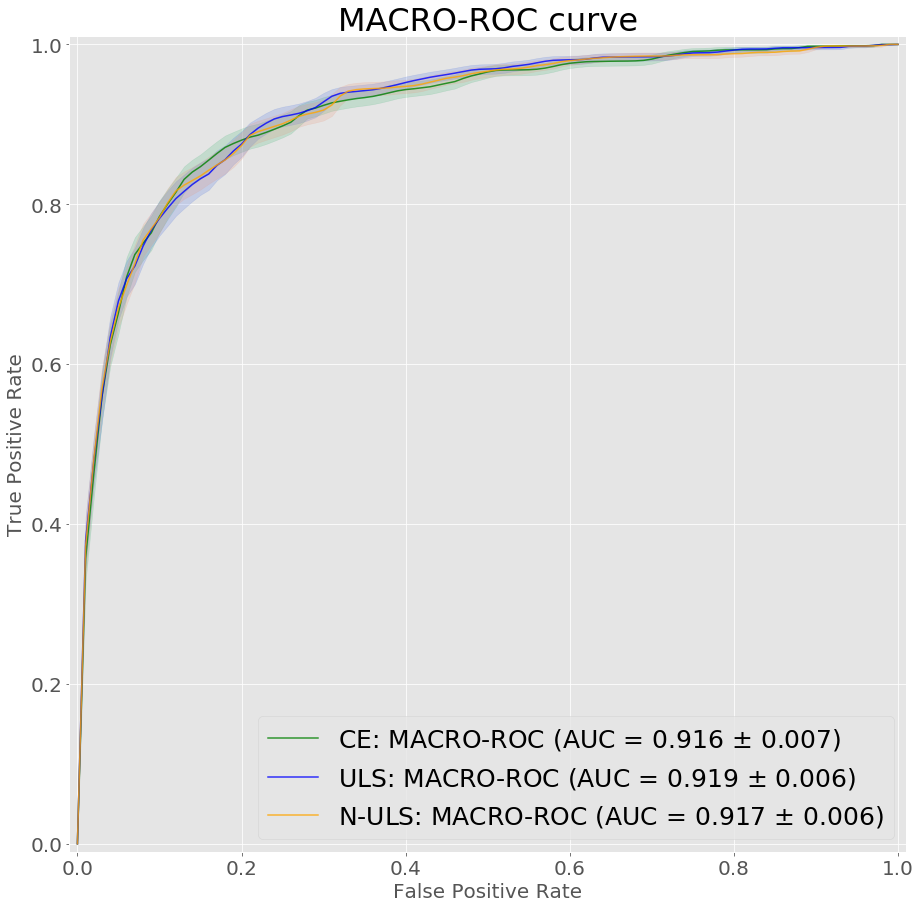

In [31]:
# plt.figure(figsize=(10,10));
width = 1

tprs = []
aucs = []
base_fpr = np.linspace(0, 1, 101)

for seed in tqdm(range(1000)):
    subset = resample(results_ce, n_samples=None, replace=True, random_state=seed, stratify = results_ce['y_true'])
    probas = np.vstack([subset.y_proba_0, subset.y_proba_1, 
                        subset.y_proba_2, subset.y_proba_3, 
                        subset.y_proba_4]).T
    
    y = label_binarize(subset.y_true, classes=[0, 1, 2, 3, 4])
    n_classes = y.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], probas[:, i])
        roc_auc[i] = auc_sk(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), probas.ravel())
    roc_auc["micro"] = auc_sk(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc_sk(fpr["macro"], tpr["macro"])
    
    if method=='MICRO':
        aucs.append(roc_auc["micro"])
        tpr = interp(base_fpr, fpr["micro"], tpr["micro"])
        tpr[0] = 0.0
        tprs.append(tpr) 
    else:
        aucs.append(roc_auc["macro"])
        tpr = interp(base_fpr, fpr["macro"], tpr["macro"])
        tpr[0] = 0.0
        tprs.append(tpr)
        
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

mean_auc = auc_sk(base_fpr, mean_tprs)
std_auc = np.std(aucs)

tprs_upper = np.minimum(mean_tprs + width*std, 1)
tprs_lower = mean_tprs - width*std

f = plt.figure()
plt.plot(base_fpr, mean_tprs, color='green', alpha = 0.8, label=r'CE: ' \
         +method+'-ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),)
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'mediumseagreen', alpha = 0.2)
#########################################################################################################
tprs = []
aucs = []
base_fpr = np.linspace(0, 1, 101)

for seed in tqdm(range(1000)):
    subset = resample(results_uls, n_samples=None, replace=True, random_state=seed, stratify = results_uls['y_true'])
    probas = np.vstack([subset.y_proba_0, subset.y_proba_1, 
                        subset.y_proba_2, subset.y_proba_3, 
                        subset.y_proba_4]).T
    
    y = label_binarize(subset.y_true, classes=[0, 1, 2, 3, 4])
    n_classes = y.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], probas[:, i])
        roc_auc[i] = auc_sk(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), probas.ravel())
    roc_auc["micro"] = auc_sk(fpr["micro"], tpr["micro"])
        
    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc_sk(fpr["macro"], tpr["macro"])

    if method=='MICRO':
        aucs.append(roc_auc["micro"])
        tpr = interp(base_fpr, fpr["micro"], tpr["micro"])
        tpr[0] = 0.0
        tprs.append(tpr) 
    else:
        aucs.append(roc_auc["macro"])
        tpr = interp(base_fpr, fpr["macro"], tpr["macro"])
        tpr[0] = 0.0
        tprs.append(tpr)


tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

mean_auc = auc_sk(base_fpr, mean_tprs)
std_auc = np.std(aucs)

tprs_upper = np.minimum(mean_tprs + width*std, 1)
tprs_lower = mean_tprs - width*std

plt.plot(base_fpr, mean_tprs, color='blue', alpha = 0.8, label=r'ULS: ' \
         +method+'-ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),)
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'royalblue', alpha = 0.2)
#########################################################################################################
tprs = []
aucs = []
base_fpr = np.linspace(0, 1, 101)

for seed in tqdm(range(1000)):
    subset = resample(results_gls, n_samples=None, replace=True, random_state=seed, stratify = results_gls['y_true'])
    probas = np.vstack([subset.y_proba_0, subset.y_proba_1, 
                        subset.y_proba_2, subset.y_proba_3, 
                        subset.y_proba_4]).T
    
    y = label_binarize(subset.y_true, classes=[0, 1, 2, 3, 4])
    n_classes = y.shape[1]

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], probas[:, i])
        roc_auc[i] = auc_sk(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), probas.ravel())
    roc_auc["micro"] = auc_sk(fpr["micro"], tpr["micro"])
    
    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc_sk(fpr["macro"], tpr["macro"])
    
    if method=='MICRO':
        aucs.append(roc_auc["micro"])
        tpr = interp(base_fpr, fpr["micro"], tpr["micro"])
        tpr[0] = 0.0
        tprs.append(tpr) 
    else:
        aucs.append(roc_auc["macro"])
        tpr = interp(base_fpr, fpr["macro"], tpr["macro"])
        tpr[0] = 0.0
        tprs.append(tpr)

    
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
std = tprs.std(axis=0)

mean_auc = auc_sk(base_fpr, mean_tprs)
std_auc = np.std(aucs)

tprs_upper = np.minimum(mean_tprs + width*std, 1)
tprs_lower = mean_tprs - width*std

plt.plot(base_fpr, mean_tprs, color='orange', alpha = 0.8, label=r'N-ULS: ' \
         +method+'-ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),)
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color = 'darksalmon', alpha = 0.2)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right")
plt.title(method+'-ROC curve', fontsize=32)
plt.show()
fig_title = 'ROC_macro_R101.png'
f.savefig(fig_title, bbox_inches='tight')

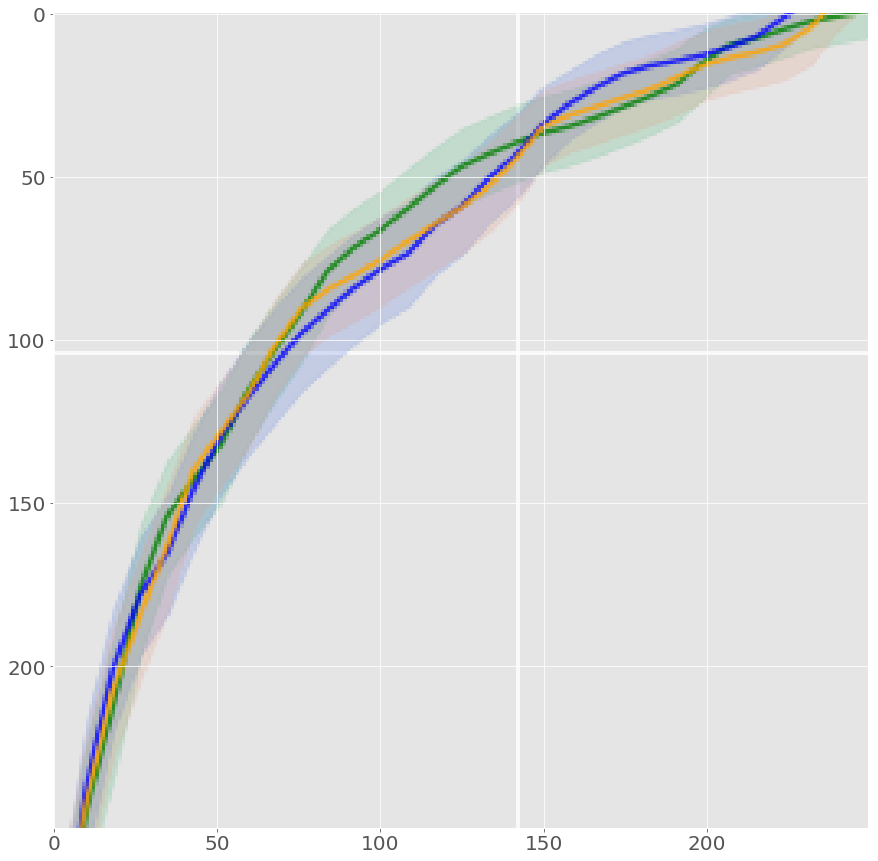

In [32]:
corner = imread('ROC_macro_R101.png')
corner.shape
c1, c2 = 100, 100
c3, c4 = c1+250, c2+250
plt.imshow(corner[c1:c3,c2:c4,:])
imsave('corner_macro_R101.png', corner[c1:c3,c2:c4,:])